In [1]:
# GPU Runtime
!nvidia-smi

Mon Jun 17 14:05:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Food_10 Dataset on GitHub
!git clone https://github.com/cbtn-data-science-ml/ml_datasets.git

Cloning into 'ml_datasets'...
remote: Enumerating objects: 38084, done.
remote: Counting objects: 100% (13080/13080), done.
remote: Compressing objects: 100% (13075/13075), done.
remote: Total 38084 (delta 8), reused 13064 (delta 0), pack-reused 25004
Receiving objects: 100% (38084/38084), 1.14 GiB | 61.64 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (39805/39805), done.


In [3]:
%pwd

'/content'

In [4]:

# navigate to repo directory
import os
os.chdir('ml_datasets')

In [5]:
%pwd

'/content/ml_datasets'

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = 'food_10/train/'
test_dir = 'food_10/test/'

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE # Cache/Prefetch data: Removes I/O bottlenecks => GPU use

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 8000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


In [7]:
!wget https://raw.githubusercontent.com/cbtn-data-science-ml/introduction-to-deep-learning/main/model_utils.py

--2024-06-17 14:06:57--  https://raw.githubusercontent.com/cbtn-data-science-ml/introduction-to-deep-learning/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2299 (2.2K) [text/plain]
Saving to: ‘model_utils.py.1’

model_utils.py.1    100%[===================>]   2.25K  --.-KB/s    in 0s      

2024-06-17 14:06:57 (41.0 MB/s) - ‘model_utils.py.1’ saved [2299/2299]



In [8]:
from model_utils import create_model_from_kaggle_tfhub, plot_loss_and_accuracy, MyCallback, early_stopping_callback, model_checkpoint_callback

In [9]:
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

initial_epochs = 10
fine_tuning_epochs = 10


# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=1,
    mode='min',
    restore_best_weights = True
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
], name="data_augmentation")

inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = data_augmentation(inputs)

base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=initial_epochs,
    validation_data=test_data,
    callbacks=[early_stopping],
    verbose=1
)




94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
250/250 [==============================] - 164s 591ms/step - loss: 0.8501 - accuracy: 0.7224 - val_loss: 0.3467 - val_accuracy: 0.8935
Epoch 2/10
250/250 [==============================] - 64s 255ms/step - loss: 0.5183 - accuracy: 0.8359 - val_loss: 0.3618 - val_accuracy: 0.8880
Epoch 3/10
250/250 [==============================] - 53s 212ms/step - loss: 0.4633 - accuracy: 0.8486 - val_loss: 0.3044 - val_accuracy: 0.9080
Epoch 4/10
250/250 [==============================] - 51s 206ms/step - loss: 0.4188 - accuracy: 0.8641 - val_loss: 0.3081 - val_accuracy: 0.9050
Epoch 5/10
250/250 [==============================] - 47s 188ms/step - loss: 0.3961 - accuracy: 0.8711 - val_loss: 0.3030 - val_accuracy: 0.9070
Epoch 6/10
250/250 [==============================] - 47s 187ms/step - loss: 0.3654 - accuracy: 0.8776 - val_loss: 0.3297 - val_accuracy: 0.8990
Epoch 7/10
250/250 [==============================] - 44s 178ms/

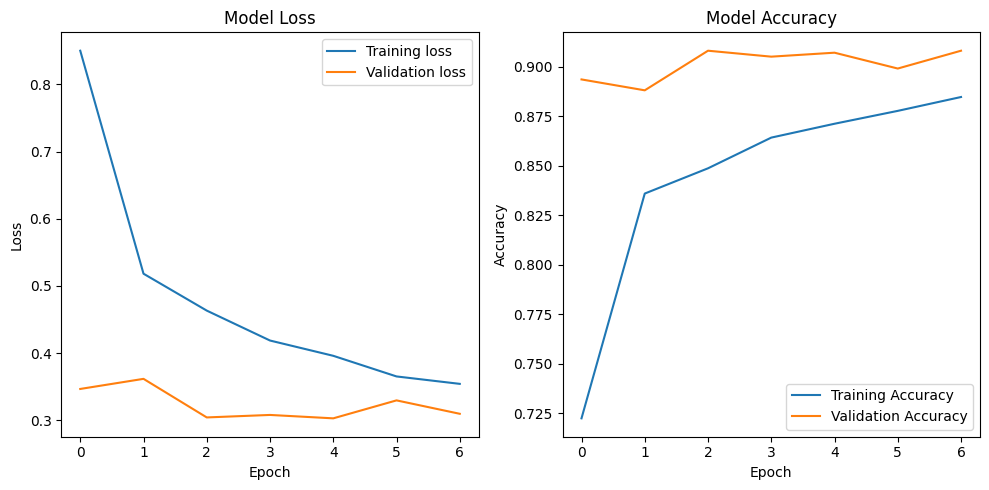

In [10]:
plot_loss_and_accuracy(history)

# CHALLENGE

In [12]:
# Begin Fine-Tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) -10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Recompile for fine-tuning
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Fine-Tuning
history_fine_tuning = model.fit(
    train_data,
    epochs=fine_tuning_epochs,
    validation_data=test_data,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/10
250/250 [==============================] - 55s 196ms/step - loss: 0.3209 - accuracy: 0.8936 - val_loss: 0.3251 - val_accuracy: 0.9060
Epoch 2/10
250/250 [==============================] - 45s 180ms/step - loss: 0.2158 - accuracy: 0.9293 - val_loss: 0.3340 - val_accuracy: 0.9140
Epoch 3/10
250/250 [==============================] - 45s 181ms/step - loss: 0.1639 - accuracy: 0.9464 - val_loss: 0.3262 - val_accuracy: 0.9120
Epoch 3: early stopping


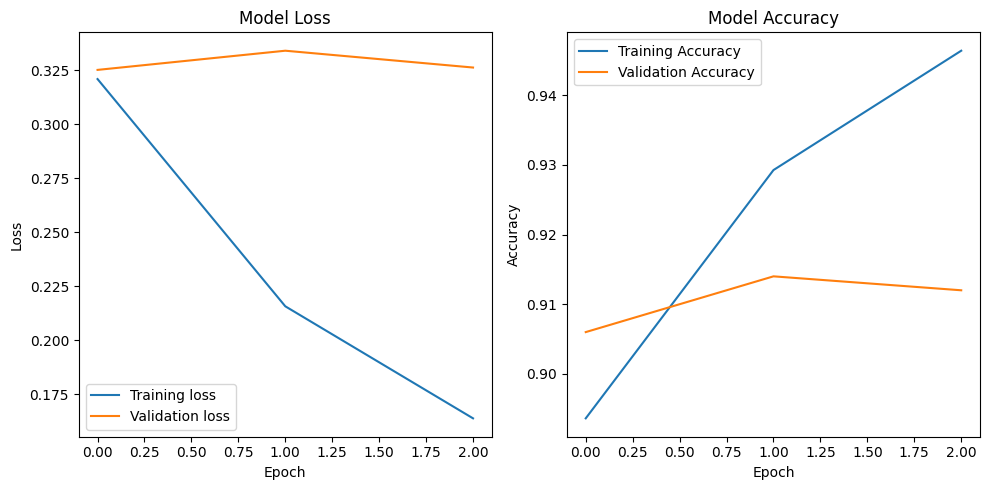

In [16]:
plot_loss_and_accuracy(history_fine_tuning)